In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import pickle
from keras import Sequential, Input, layers
from evaluation_util import summarize_metric, plot_roc_curve, plot_confusion_matrix
import random

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [2]:

data_dir ='data' # Change to the path to your directory
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')

# 1. Load saved train, val, test datasets and class names

In [3]:
# Load the arrays from the saved files
X_train = np.load(f'{data_dir}/X_train.npy')
y_train = np.load(f'{data_dir}/y_train.npy')
X_val = np.load(f'{data_dir}/X_val.npy')
y_val = np.load(f'{data_dir}/y_val.npy')

X_test = np.load(f'{data_dir}/X_test.npy')
y_test = np.load(f'{data_dir}/y_test.npy')

print("Training and validation datasets have been loaded successfully.")

with open(f'{data_dir}/class_names_train.pkl', 'rb') as file:
    class_names_train = pickle.load(file)

with open(f'{data_dir}/class_names_test.pkl', 'rb') as file:
    class_names_test = pickle.load(file)

print(f"Loaded class names: {class_names_train} {class_names_test}")
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

Training and validation datasets have been loaded successfully.
Loaded class names: ['glioma', 'meningioma', 'notumor', 'pituitary'] ['glioma', 'meningioma', 'notumor', 'pituitary']
(4608, 30, 30, 1) (1104, 30, 30, 1) (1311, 30, 30, 1)
(4608, 4) (1104, 4) (1311, 4)


# 2. Define model

In [4]:
def baseline():
    baseline = Sequential()
    baseline.add(Input(shape = (30, 30, 1)))
    baseline.add(layers.Conv2D(32, (3, 3), activation = "relu"))
    baseline.add(layers.MaxPooling2D((2, 2)))
    baseline.add(layers.Conv2D(32, (3, 3), activation = "relu"))
    baseline.add(layers.MaxPooling2D((2, 2)))
    baseline.add(layers.Flatten())
    baseline.add(layers.Dense(32, activation = "relu"))
    baseline.add(layers.Dense(4, activation = "softmax"))
    baseline.compile(optimizer = "adam",
                    loss = "categorical_crossentropy",
                    metrics = ["accuracy"])
    return baseline

# 3. Start training and evaluation

Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4378 - loss: 1.1887 - val_accuracy: 0.6721 - val_loss: 0.8587
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7181 - loss: 0.7542 - val_accuracy: 0.7292 - val_loss: 0.7105
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7694 - loss: 0.6324 - val_accuracy: 0.7409 - val_loss: 0.6542
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7905 - loss: 0.5691 - val_accuracy: 0.7527 - val_loss: 0.6271
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8032 - loss: 0.5271 - val_accuracy: 0.7591 - val_loss: 0.6109
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8193 - loss: 0.4926 - val_accuracy: 0.7690 - val_loss: 0.6061
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8308 - loss: 0.4606 - val_accuracy: 0.7672 - val_loss: 0.6051
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8449 - loss: 0.4323 - val_accuracy: 0

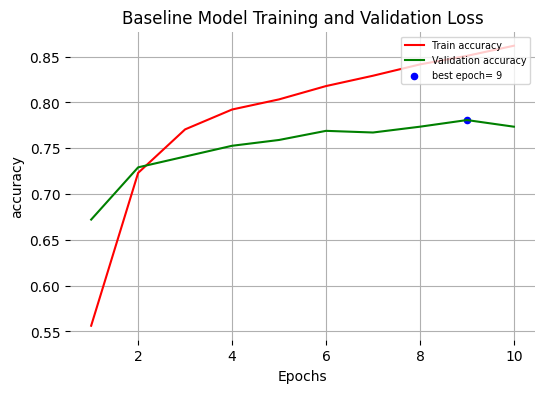

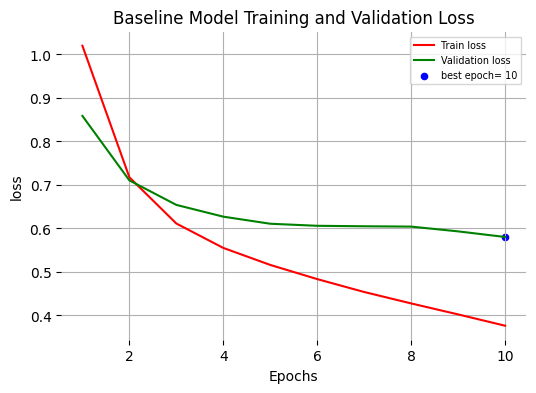

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


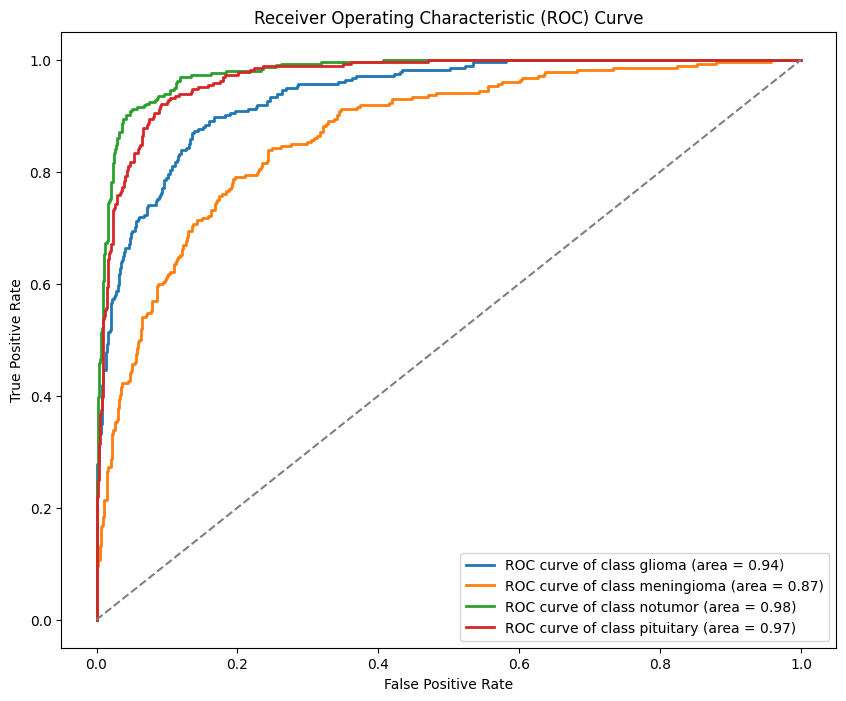

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


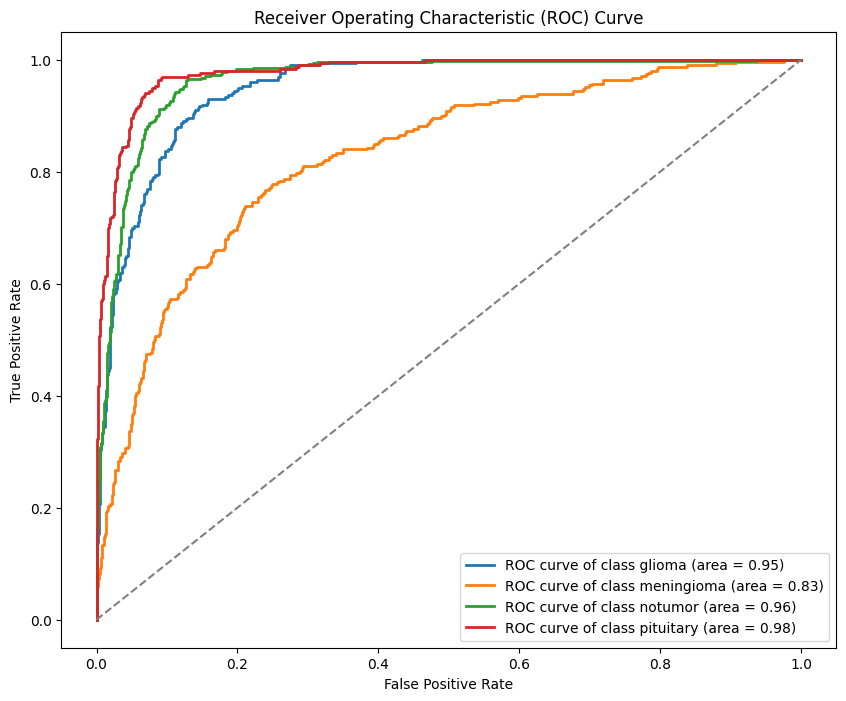

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


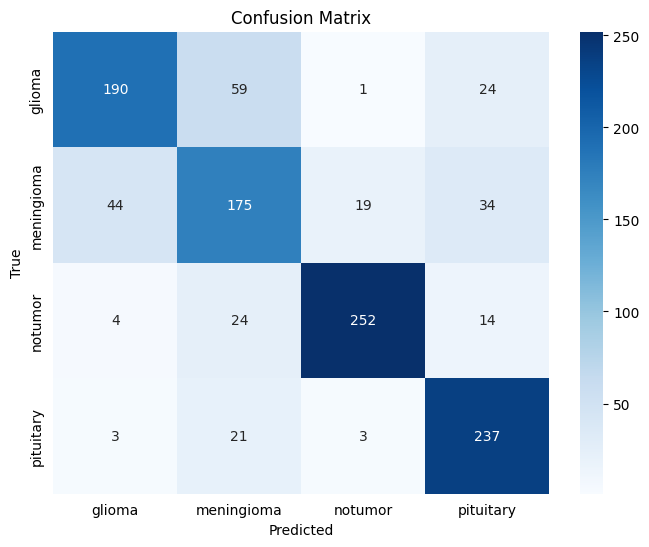

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


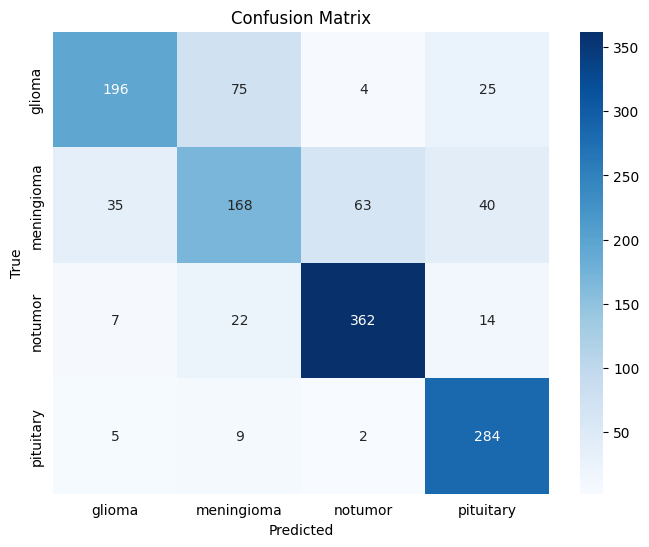

In [5]:
base = baseline()
history = base.fit(X_train, y_train, batch_size =32, epochs = 10, validation_data = (X_val, y_val))

summarize_metric(history, "accuracy")
summarize_metric(history, "loss")

roc_auc_val = plot_roc_curve(base, X_val, y_val, class_names_train)
roc_auc_test = plot_roc_curve(base, X_test, y_test, class_names_test)

plot_confusion_matrix(base, X_val, y_val, class_names_train, normalize=False)
plot_confusion_matrix(base, X_test, y_test, class_names_test, normalize=False)